In [1]:
# import the necessary libraries
import torch
import pytorchvideo
from pytorchvideo.data import LabeledVideoDataset,Kinetics, make_clip_sampler,labeled_video_dataset

from pytorchvideo.transforms import(
    ApplyTransformToKey,Normalize,RandomShortSideScale,Permute,UniformTemporalSubsample,  ShortSideScale
)

from torchvision.transforms import(
    Compose,Lambda,RandomCrop,RandomHorizontalFlip,Resize,
)
from torchvision.transforms._transforms_video import(
    CenterCropVideo,
    NormalizeVideo
)
import torch.nn as nn
import torch
from pytorch_lightning import LightningModule,seed_everything,Trainer
from pytorch_lightning.callbacks import ModelCheckpoint,LearningRateMonitor
from torch.optim.lr_scheduler import CosineAnnealingLR,ReduceLROnPlateau
from sklearn.metrics import classification_report
import torchmetrics
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import numpy as np
import pytorchvideo
import pytorch_lightning as pl
import pytorchvideo.models.hub.slowfast as slowfast
from lion_pytorch import Lion
import pytorchvideo.models.hub.x3d as x3d


/data/thinhlv/data/anaconda/envs/khanhlinh/lib/python3.9/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in 0.14. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/data/thinhlv/data/anaconda/envs/khanhlinh/lib/python3.9/site-packages/torchvision/transforms/_transforms_video.py:25: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in 0.14. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


In [3]:
#  Define the transform video data
side_size = 300
mean = [0.45, 0.45, 0.45]
std = [0.225, 0.225, 0.225]
crop_size = 256
num_frames = 32
sampling_rate = 2
frames_per_second = 30
slowfast_alpha = 4
num_clips = 10
num_crops = 3

class PackPathway(torch.nn.Module):
    """
    Transform for converting video frames as a list of tensors. 
    """
    def __init__(self):
        super().__init__()
        
    def forward(self, frames: torch.Tensor):
        fast_pathway = frames
        # Perform temporal sampling from the fast pathway.
        slow_pathway = torch.index_select(
            frames,
            1,
            torch.linspace(
                0, frames.shape[1] - 1, frames.shape[1] // slowfast_alpha
            ).long(),
        )
        frame_list = [slow_pathway, fast_pathway]
        return frame_list

transform =  ApplyTransformToKey(
    key="video",
    transform=Compose(
        [
            UniformTemporalSubsample(num_frames),
            Lambda(lambda x: x/255.0),
            NormalizeVideo(mean, std),
            ShortSideScale(
                size=side_size
            ),
            CenterCropVideo(crop_size),
            PackPathway()
        ]
    ),
)
train_transform =  ApplyTransformToKey(
    key="video",
    transform=Compose(
        [
            UniformTemporalSubsample(num_frames),
            Lambda(lambda x: x/255.0),
            NormalizeVideo(mean, std),
            RandomShortSideScale(min_size=256, max_size=320),
            RandomCrop(256),
            RandomHorizontalFlip(p=0.5),
            ShortSideScale(
                size=side_size
            ),
            CenterCropVideo(crop_size),
            PackPathway()
        ]
    ),
)

# The duration of the input clip is also specific to the model.
clip_duration = (num_frames * sampling_rate)/frames_per_second

In [5]:
# Define the model using slowfast_r50 is backbone model and backend is pytorch lightning
import os
from torch.utils.data import DataLoader
NUM_WORKERS =  os.cpu_count() or 0
from torchmetrics.classification import BinaryAccuracy,BinaryF1Score
class videoClassifer(LightningModule):
    def __init__(self) -> None:
        super().__init__()
        self.prepresentation=slowfast.slowfast_r50(pretrained=True) # slowfast_r50 is pretrained model
        self.prepresentation.blocks[6].proj=nn.Linear(in_features=2304, out_features=1000, bias=True) # modify project layer to vector prepresentation 
        
        self.fc=nn.Sequential( # Define fully connected
            nn.Linear(in_features=1000, out_features=500),
            nn.ReLU(),
            nn.Linear(in_features=500,out_features=400),
            nn.ReLU(),
            
            nn.Linear(in_features=400,out_features=1)
        )
        for param in self.prepresentation .blocks[:] .parameters(): # Freeze parameters of pretrained model
            param.requires_grad = False
        
        
    
        
            
        self.lr=1e-2 # learning rate
       
        self.batch_size=16 

        self.numworker=NUM_WORKERS 
        # evalation
        self.metrics=BinaryAccuracy().to(self.device)  # Define Accuracy metris
        self.F1_score=BinaryF1Score().to(self.device) # Define F1 Score 
        
      

        self.criterion=nn.BCEWithLogitsLoss() # Loss function
    
    

    def forward(self,x):
        x=self.prepresentation(x)
        x=self.fc(x)

        return x
    def configure_optimizers(self):
        
        
        opt = Lion(params=self.parameters(),lr=self.lr, weight_decay=1e-2)  # Optimizer
        scheduler=CosineAnnealingLR(optimizer=opt,T_max=10,eta_min=1e-5,last_epoch=-1) # scheduler purpose control 
        return {"optimizer":opt,"lr_scheduler":scheduler}
    # define train dataloader to load dataset from folder 
    def train_dataloader(self):
        dataset=labeled_video_dataset("data/train",clip_sampler=make_clip_sampler("random",2),transform=transform ,decode_audio=False)
        loader=DataLoader(dataset,batch_size=self.batch_size,num_workers=self.numworker,pin_memory=True)
        return loader
    # Define training step through training model 
    def training_step(self,batch,batch_idx):
        video,label=batch["video"],batch["label"].to(torch.float32).detach()  # 
        out=self(video).squeeze(1) 
        loss=self.criterion(out,label) # loss function  
        return {"loss":loss,'preds': out.detach(), 'target': label}
    
    # define validation dataloader to load dataset from folder 
    
    def val_dataloader(self):
        dataset=labeled_video_dataset("data/val",clip_sampler=make_clip_sampler("random",2),transform=transform,decode_audio=False)
        loader=DataLoader(dataset,batch_size=self.batch_size,num_workers=self.numworker,pin_memory=True)
        return loader
    # Define validation step through training model 
    
    def validation_step(self,batch,batch_idx):
        video,label=batch["video"],batch["label"].to(torch.float32).detach()
        out=self(video).squeeze(1) 
        loss=self.criterion(out,label)
        return {"loss":loss,'preds': out.detach(), 'target': label}
        
    # Define testing dataloader
    def test_dataloader(self):
        dataset=labeled_video_dataset("data/test",clip_sampler=make_clip_sampler("random",2),transform=transform,decode_audio=False)
        loader=DataLoader(dataset,batch_size=self.batch_size,num_workers=self.numworker,pin_memory=True)
        return loader
    
    def test_step(self,batch,batch_idx):
        video,label=batch["video"],batch["label"]
        out=self(video).squeeze(1) 
        return {"label":label.detach(),"pred":out.detach()}
    def test_epochs_end(self, outputs):
        label=torch.cat([x["label"] for x in outputs]).cpu().numpy()
        pred=torch.cat([x["pred"] for x in outputs]).cpu().numpy()
        pred=np.where(pred>0.5,1,0)
        print(classification_report(label,pred))
    # When end epoch training logging some metrics and loss function
    def training_epoch_end(self, outputs):
       
        avg_loss = torch.cat([x['loss'].reshape(-1,1) for x in outputs],0).mean()
        preds = torch.cat([x['preds'] for x in outputs], dim=0)
        target = torch.cat([x['target'] for x in outputs], dim=0)
    
        
        self.F1_score.update(preds, target)
        self.metrics.update(preds, target)
        
        metric_value = self.metrics.compute()
        F1_score=self.F1_score.compute()
       
        self.log('train_loss', avg_loss, on_epoch=True)
        self.log('train_metric', metric_value, on_epoch=True)
        self.log("train_f1_score",F1_score,on_epoch=True)

    # When end epoch testing logging some metrics and loss function

    def validation_epoch_end(self, outputs):
        avg_loss = torch.cat([x['loss'].reshape(-1,1) for x in outputs],0).mean()
        preds = torch.cat([x['preds'] for x in outputs], dim=0)
        target = torch.cat([x['target'] for x in outputs], dim=0)
    
        self.F1_score.update(preds, target)
        self.metrics.update(preds, target)
        metric_value = self.metrics.compute()
        F1_score=self.F1_score.compute()
        self.F1_score.update(preds, target)
        self.log('val_loss', avg_loss, on_epoch=True)
        self.log('val_metric', metric_value, on_epoch=True)
        self.log("val_f1_score",F1_score,on_epoch=True)
        


In [6]:

model=videoClassifer() # initialize model

In [10]:
''' Initialize the logger'''
import wandb
from lightning.pytorch.loggers import WandbLogger
wandb_logger = WandbLogger(project="Video_classify",job_type='train')



In [11]:
checkpoint_callback=ModelCheckpoint(monitor="val_loss",dirpath=r"/checkpoint",filename="VideoClassifierSlowFast_r50_300",save_last=True) #  Checkpoint callback to save checkpoint model
lr_monitor=LearningRateMonitor(logging_interval="epoch") # Monitor learning rate
early_stop_callback = EarlyStopping(monitor="val_accuracy", min_delta=0.00, patience=3, verbose=False, mode="max") # Early stopping callback 

In [12]:
trainer = Trainer(accelerator="gpu", devices=[0,1,2,3], # trainer device 
                  callbacks=[lr_monitor,checkpoint_callback], 
                  enable_progress_bar=True,logger=wandb_logger,strategy='dp'
                  ,max_epochs=100)

In [13]:
trainer.fit(model) # fitting model

In [14]:
# load the model from checkpoint file
model_classifier=videoClassifer.load_from_checkpoint(r"checkpoint/VideoClassifierSlowFast_50_size_300.ckpt") # load the model from checkpoint file

In [15]:
test_loader=model_classifier.test_dataloader() # load test dataloader

In [16]:
import time

predicts = []
labels = []
start_time = time.time()
# num_samples = len(test_loader)
model_classifier.eval()
for batch in test_loader:
    video = batch["video"]
    label = batch["label"]
    
    preds = model_classifier(video)
    post_act = torch.nn.Sigmoid()

    preds = post_act(preds)
    preds = preds > 0.5
    predicts.append(preds[0].numpy())
    labels.append(label[0].numpy())

end_time = time.time()
total_time = end_time - start_time
avg_time_per_sample = total_time / 64
print(f"Total prediction time: {total_time:.2f} seconds")
print(f"Average prediction time per sample: {avg_time_per_sample:.4f} seconds")

Total prediction time: 36.28 seconds
Average prediction time per sample: 0.5669 seconds


In [17]:
print(classification_report(y_pred=predicts,y_true=labels))

              precision    recall  f1-score   support

           0       0.78      0.75      0.77        24
           1       0.85      0.88      0.86        40

    accuracy                           0.83        64
   macro avg       0.82      0.81      0.82        64
weighted avg       0.83      0.83      0.83        64



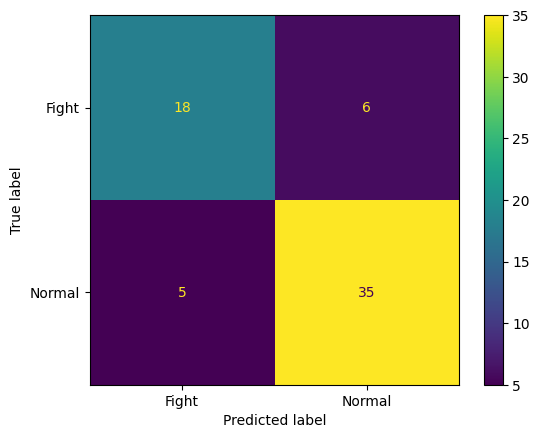

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
mt=confusion_matrix(y_pred=predicts,y_true=labels)
disp=ConfusionMatrixDisplay(mt,display_labels=["Fight","Normal"])
disp.plot()

In [20]:
video_path=r"/data/test/Fight/_q5Nwh4Z6ao_6.avi"
# Load video data
from pytorchvideo.data.encoded_video import EncodedVideo
start_sec = 0
end_sec = start_sec + clip_duration

# Initialize an EncodedVideo helper class and load the video
video = EncodedVideo.from_path(video_path)

# Load the desired clip
video_data = video.get_clip(start_sec=start_sec, end_sec=end_sec)
video_data = transform(video_data)
inputs = video_data["video"]
inputs = [i[None, ...] for i in inputs]

preds = model_classifier(inputs)

# Get the predicted classes
post_act = torch.nn.Sigmoid()
preds = post_act(preds)
labels_names=["Fight","Normal"]
print(preds)
print(labels_names[preds[0]>0.5])

tensor([[0.0097]], grad_fn=<SigmoidBackward0>)
Fight
